In [15]:
import lxml
from lxml import objectify

class TsaiCamera(object):
    # TODO: use matrices properly
    '''tsai camera model'''
    
    def __init__(self, path):
        '''path - path to configuration .xml'''
        xml_root = lxml.objectify.parse(f).getroot()
        
        for key,val in xml_root.Geometry.attrib.iteritems():
            self.__dict__[key] = float(val)
        for key,val in xml_root.Intrinsic.attrib.iteritems():
            self.__dict__[key] = float(val)
        for key,val in xml_root.Extrinsic.attrib.iteritems():
            self.__dict__[key] = float(val)

        self.t = np.array([[self.tx,self.ty,self.tz]]).T
        
        sa, ca = np.sin(self.rx), np.cos(self.rx)
        sb, cb = np.sin(self.ry), np.cos(self.ry)        
        sg, cg = np.sin(self.rz), np.cos(self.rz)                

        self.R = np.zeros((3,3))
        self.R[0,0] = cb * cg
        self.R[0,1] = cg * sa * sb - ca * sg
        self.R[0,2] = sa * sg + ca * cg * sb
        self.R[1,0] = cb * sg
        self.R[1,1] = sa * sb * sg + ca * cg
        self.R[1,2] = ca * sb * sg - cg * sa
        self.R[2,0] = -sb
        self.R[2,1] = cb * sa
        self.R[2,2] = ca * cb
        
        self.cpos = - self.R.T.dot(self.t)
            
    def image_to_world(self, pi, zw):
        Xd = self.dpx * (pi[0] - self.cx) / self.sx
        Yd = self.dpy * (pi[1] - self.cy)

        Xu, Yu = self.distorted_to_undistorted_sensor(Xd, Yd)

        common_denominator = ((self.R[0,0] * self.R[2,1] - self.R[0,1] * self.R[2,0]) * Yu +
                              (self.R[1,1] * self.R[2,0] - self.R[1,0] * self.R[2,1]) * Xu -
                              self.focal * self.R[0,0] * self.R[1,1] + self.focal * self.R[0,1] * self.R[1,0])

        pw = np.zeros((4,1))
        pw[0] = (((self.R[0,1] * self.R[2,2] - self.R[0,2] * self.R[2,1]) * Yu +
               (self.R[1,2] * self.R[2,1] - self.R[1,1] * self.R[2,2]) * Xu -
               self.focal * self.R[0,1] * self.R[1,2] + self.focal * self.R[0,2] * self.R[1,1]) * zw +
              (self.R[0,1] * self.t[2] - self.R[2,1] * self.t[0]) * Yu +
                (self.R[2,1] * self.t[1] - self.R[1,1] * self.t[2]) * Xu -
                self.focal * self.R[0,1] * self.t[1] + self.focal * self.R[1,1] * self.t[0]) / common_denominator;

        pw[1] = -(((self.R[0,0] * self.R[2,2] - self.R[0,2] * self.R[2,0]) * Yu +
                (self.R[1,2] * self.R[2,0] - self.R[1,0] * self.R[2,2]) * Xu -
                self.focal * self.R[0,0] * self.R[1,2] + self.focal * self.R[0,2] * self.R[1,0]) * zw +
               (self.R[0,0] * self.t[2] - self.R[2,0] * self.t[0]) * Yu +
                (self.R[2,0] * self.t[1] - self.R[1,0] * self.t[2]) * Xu -
                self.focal * self.R[0,0] * self.t[1] + self.focal * self.R[1,0] * self.t[0]) / common_denominator;
        pw[2] = zw
        pw[3] = 1.0        
        return pw
    
    def world_to_image(self, pw):
        pi = np.zeros((2,1))
        xc = self.R[0,0] * pw[0] + self.R[0,1] * pw[1] + self.R[0,2] * pw[2] + self.t[0]
        yc = self.R[1,0] * pw[0] + self.R[1,1] * pw[1] + self.R[1,2] * pw[2] + self.t[1]
        zc = self.R[2,0] * pw[0] + self.R[2,1] * pw[1] + self.R[2,2] * pw[2] + self.t[2]

        Xu, Yu = self.focal * xc / zc, self.focal * yc / zc

        Xd, Yd = self.undistorted_to_distorted_sensor(Xu, Yu)

        pi[0] = Xd * self.sx / self.dpx + self.cx
        pi[1] = Yd / self.dpy + self.cy

        return pi
    
    def world_to_camera(self, pw):
        pc = np.zeros((3,1))
        pc[0] = self.R[0,0] * pw[0] + self.R[0,1] * pw[1] + self.R[0,2] * pw[2] + self.t[0]
        pc[1] = self.R[1,0] * pw[0] + self.R[1,1] * pw[1] + self.R[1,2] * pw[2] + self.t[1]
        pc[2] = self.R[2,0] * pw[0] + self.R[2,1] * pw[1] + self.R[2,2] * pw[2] + self.t[2]
        return pc
    
    def camera_to_world(self, pc):
        pw = np.zeros((4,1))
        
        # TODO: matrix form
        common_denominator = ((self.R[0,0] * self.R[1,1] - self.R[0,1] * self.R[1,0]) * self.R[2,2] +
                              (self.R[0,2] * self.R[1,0] - self.R[0,0] * self.R[1,2]) * self.R[2,1] +
                              (self.R[0,1] * self.R[1,2] - self.R[0,2] * self.R[1,1]) * self.R[2,0])

        pw[0] = ((self.R[0,1] * self.R[1,2] -self.R[0,2] * self.R[1,1]) * pc[2] +
              (self.R[0,2] * self.R[2,1] - self.R[0,1] * self.R[2,2]) * pc[1] +
              (self.R[1,1] * self.R[2,2] - self.R[1,2] * self.R[2,1]) * pc[0] +
              (self.R[0,2] * self.R[1,1] - self.R[0,1] * self.R[1,2]) * self.t[2] +
                (self.R[0,1] * self.R[2,2] - self.R[0,2] * self.R[2,1]) * self.t[1] +
                (self.R[1,2] * self.R[2,1] - self.R[1,1] * self.R[2,2]) * self.t[0]) / common_denominator

        pw[1] = -((self.R[0,0] * self.R[1,2] - self.R[0,2] * self.R[1,0]) * pc[2] +
               (self.R[0,2] * self.R[2,0] - self.R[0,0] * self.R[2,2]) * pc[1] +
               (self.R[1,0] * self.R[2,2] - self.R[1,2] * self.R[2,0]) * pc[0] +
               (self.R[0,2] * self.R[1,0] - self.R[0,0] * self.R[1,2]) * self.t[2] +
                (self.R[0,0] * self.R[2,2] - self.R[0,2] * self.R[2,0]) * self.t[1] +
                (self.R[1,2] * self.R[2,0] - self.R[1,0] * self.R[2,2]) * self.t[0]) / common_denominator

        pw[2] = ((self.R[0,0] * self.R[1,1] - self.R[0,1] * self.R[1,0]) * pc[2] +
              (self.R[0,1] * self.R[2,0] - self.R[0,0] * self.R[2,1]) * pc[1] +
              (self.R[1,0] * self.R[2,1] - self.R[1,1] * self.R[2,0]) * pc[0] +
              (self.R[0,1] * self.R[1,0] - self.R[0,0] * self.R[1,1]) * self.t[2] +
                (self.R[0,0] * self.R[2,1] - self.R[0,1] * self.R[2,0]) * self.t[1] +
                (self.R[1,1] * self.R[2,0] - self.R[1,0] * self.R[2,1]) * self.t[0]) / common_denominator 
        
        pw[3] = 1.0
        return pw
        
    def camera_to_image(self, pc):
        return self.world_to_image(self.camera_to_world(pc))
    
    def distorted_to_undistorted_sensor(self, Xd, Yd):
        distortion_factor = 1 + self.kappa1 * (Xd*Xd + Yd*Yd)
        return Xd * distortion_factor, Yd * distortion_factor
    
    def undistorted_to_distorted_sensor(self, Xu, Yu):

        if ((Xu == 0) and (Yu == 0)) or (self.kappa1 == 0):
            return Xu, Yu

        Ru = np.sqrt(Xu*Xu + Yu*Yu);

        c = 1.0 / self.kappa1;
        d = -c * Ru;

        Q = c / 3;
        R = -d / 2;
        D = Q*Q*Q + R*R;

        if D >= 0:
            D = np.sqrt(D)
            S = (R + D)**(1.0/3.0) if (R + D > 0) else -((-R - D)**(1.0/3.0))
            T = (R - D)**(1.0/3.0) if (R - D > 0) else -((D - R)**(1.0/3.0))
            Rd = S + T

            if Rd < 0:
                Rd = np.sqrt(-1.0 / (3 * self.kappa1))
        else:
            D = sqrt(-D);
            S = np.sqrt(R*R + D*D)**(1.0/3.0)
            T = np.arctan2(D, R) / 3
            Rd = -S * cos(T) + np.sqrt(3.0) * S * sin(T)

        return (Xu * Rd / Ru), (Yu * Rd / Ru)
    

In [9]:
def draw_grid(img, camera, length=500, rows=5, cols=5, height=0, color=[0,255,0], rad=2, thickness=2):
    '''draws a rectangular grid given camera model'''
    for x in range(0, length*rows, length):
        for y in range(0, length*cols, length):
            p0 = camera.world_to_image([x,y,height,1]).astype(np.int)
            cv2.circle(img, (p0[0],p0[1]), rad, color, thickness)
        
def location_to_world(lid, rows, cols, cell_size):
    '''converts location id to world coordinates of the cell'''
    row, col = int(lid / rows), int(lid % cols)
    return np.array([row * cell_size, col * cell_size, 0, 1])
    
def generate_silhouette_at(pw, width, height, camera):
    '''create a single silhouette 
    pw - ground plane location 
    width, height - size of the silhouette in mm
    camera - e.g. TsaiCamera
    '''
    cb = camera.world_to_camera(pw)
    ct = camera.world_to_camera(pw - [0, 0, height, 0])

    pc = {}
    delta = np.array([[0.5*width, 0, 0]]).T
    pc[0] = cb - delta
    pc[1] = cb + delta
    pc[2] = ct - delta
    pc[3] = ct + delta
    
    vw, vh = camera.width-1, camera.height-1
    xmin, ymin, xmax, ymax = vw, vh, 0.0, 0.0
    
    for i in range(0,4):
        pi = camera.camera_to_image(pc[i])
        xmin, ymin = min(pi[0], xmin), min(pi[1], ymin)
        xmax, ymax = max(pi[0], xmax), max(pi[1], ymax)

    xmin, ymin = max(min(xmin, vw), 0), max(min(ymin, vh), 0)  
    xmax, ymax = max(min(xmax, vw), 0), max(min(ymax, vh), 0)

    visible = bool(xmin < camera.width-1 and 
                   ymin < camera.height-1 and 
                   xmax > 0 and ymax > 0)
    return map(int,[xmin,ymin,xmax,ymax])+[visible]
        
        
def generate_silhouettes(rows, cols, cell_size, width, height, cameras):
    '''
    rows, cols - # of cells in the grid
    cell_size - size of a cell in the ground plane in mm
    width, height - sizes of the silhouette box in mm
    cameras - dict of cameras
    returns a { camera_id : {location_id : silhouette} }
    '''
    sils = {}
    for cid in cameras.keys():
        sils[cid] = {} 
        for lid in range(rows*cols):
            pw = location_to_world(lid, rows, cols, cell_size)
            sils[cid][lid] = generate_silhouette_at(pw, width, height, cameras[cid])
    return sils

def save_silhouettes(path, sils, cameras, cid=0):
    '''save silhouettes to a file
    cid - the camera id to extract settings from'''
    cam = cameras[cid]
    with open(path, 'w') as out:
        out.write('ROOM %d %d %d %d\n' % (cam.width, cam.height, len(cameras), len(sils[cid])))
        for cid in sorted(sils.keys()):
            for lid in sorted(sils[cid].keys()):
                sil = sils[cid][lid]
                if sil[-1]:
                    out.write('RECTANGLE %d %d %d %d %d %d\n' % (cid, lid, sil[0], sil[1], sil[2], sil[3]))
                else:
                    out.write('RECTANGLE %d %d invisible\n' % (cid, lid))


# check calibration and silhouette generation

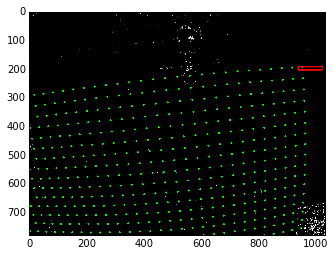

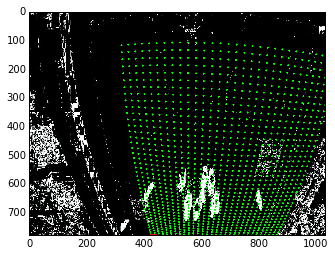

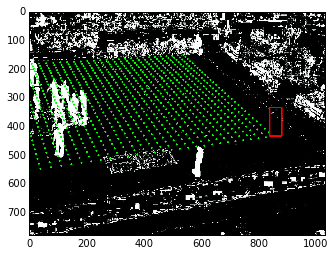

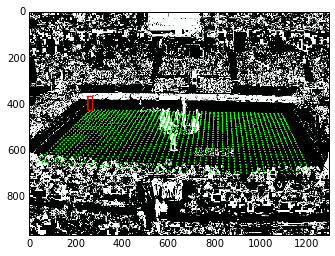

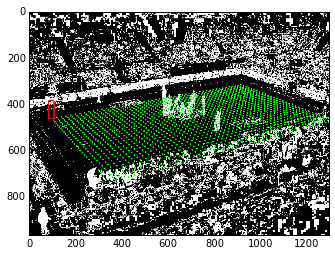

In [14]:
# loading camera configuration
data_path = '<FILL ME IN>'
cameras = {}
n_cameras = 5
for cid in range(5):
    with open(data_path + 'config/calibration_cam%d.xml' % cid) as f:
        cameras[cid] = TsaiCamera(f)

# checking calibration and silhouettes
fid = 0
n_rows, n_cols = 50, 30
sil_width, sil_height = 400, 1900
cell_size = 500

for cid in range(5):
    frame = cv2.imread(data_path + 'frames/c%d-f%04d.png' % (cid, fid))
    draw_grid(frame, cameras[cid], rows=n_rows, cols=n_cols)
    pw = location_to_world(0, n_rows, n_cols, cell_size)
    sil = generate_silhouette_at(pw, sil_width, sil_height, cameras[cid])
    cv2.rectangle(frame, (sil[0],sil[1]), (sil[2],sil[3]), [255,0,0], 4)
    plt.figure()
    plt.imshow(frame)


# generating all the silhouettes 

In [13]:
# generating all the silhouettes and writing them into pom format
sils = generate_silhouettes(n_rows, n_cols, cell_size, sil_width, sil_height, cameras)
save_silhouettes(data_path + 'config/silhouettes.pom', sils, cameras)